In [1]:
%matplotlib inline
import itertools
import numpy as np
import time
import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
import pandas as pd
plt.style.use("ggplot")

# for reproducibility of this notebook:
rng = np.random.RandomState(123)
tf.random.set_seed(42)


gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

In [11]:

what = 'PM10'
res = 200
g = 10
root = 1.3 # 1/1.3




In [12]:
categories = {'PM10':[50,100,250,350,430], 'PM3':[30,60,90,120,250]}

def convert(y):
    
    ret = []
    lim = categories[what]
    for i in y:
#         print(i)
        if i<lim[0]:
            ret.append(0.)
        elif i<lim[1]:
            ret.append(1.)
        elif i<lim[2]:
            ret.append(2.)
        elif i<lim[3]:
            ret.append(3.)
        elif i<lim[4]:
            ret.append(4.)
        else:
            ret.append(5.)
            
    return np.array(ret).reshape(-1,1)

<AxesSubplot:>

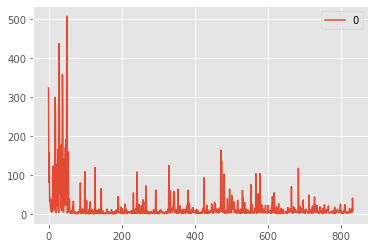

In [13]:
df = pd.read_csv('./data_corrected.csv')

Xarr = df[['LAT','LON']].values[::g]
Yarr = df[what].values[::g].reshape(-1,1)
# pd.DataFrame(Yarr).plot()

In [14]:


# Yarr = convert(Yarr)

X = Xarr.astype(np.float64)
Y = Yarr.astype(np.float64)


# Y /= categories[which][0]


# df.PM10.plot()


# Y = np.where(Y>200, 210, Y) 



mn=Y.mean()
sd=Y.std()
mi=Y.min()
mx= Y.max()

# Y = np.log10(Y+1) - np.log10(categories[what][2])

# Y = Y / categories[what][-1]




Y -= mi
Y /= mx 


# Y -= mn
# Y /= sd







# plt.figure()
# for i in range(1,100,20):
#     plt.plot(range(len(X)),Y**(1/(1- i/100)),label='%.1f'%(1-i/100),alpha = .8)
# plt.legend()

# plt.figure()
# for i in range(1,100,20):
#     plt.plot(range(len(X)),Y**(i/100),label='%.1f'%(1-i/100),alpha = .8)
# plt.legend()



Y = Y**(root)#1.1th root

Xm = X.mean(axis=0)
Xs = X.std(axis=0)

X-= Xm
X/= Xs

Y.shape,X.shape

((833, 1), (833, 2))

In [20]:
# Change noise parameter
sigma_n = 100.0
# Construct models with initial guess
# k = gpflow.kernels.SquaredExponential(active_dims=[0,1], lengthscales=[0.1,0.1])+ \
#     gpflow.kernels.Matern52(active_dims=[0,1],lengthscales=[0.10,1.0])
# k.ard=True

k = gpflow.kernels.Matern52(active_dims=[0,1],lengthscales=[1,1]) + gpflow.kernels.Matern52(active_dims=[0,1],lengthscales=[1.5,1.5])

m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

# m.likelihood.variance=sigma_n

opt = gpflow.optimizers.Scipy()

opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=4000))
print_summary(m)
print(Y.max(),Y.min(),Y.std())
pd.DataFrame(X).describe()



name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0001134365794043482
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(2,)",float64,[15266.11259586 910.40127638]
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.00044495494339932785
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.04928396 0.05353826]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.003832604758083258


0.9998758817342679 0.0 0.0682160899022128


,0,1
count,8.330000e+02,8.330000e+02
mean,-1.419755e-12,-1.808344e-15
std,1.000601e+00,1.000601e+00
min,-1.836717e+00,-1.641454e+00
25%,-6.245132e-01,-8.014693e-01
50%,-1.370505e-01,1.967828e-01
75%,4.576893e-01,8.532505e-01
max,2.470668e+00,1.577543e+00


predicting
predicted


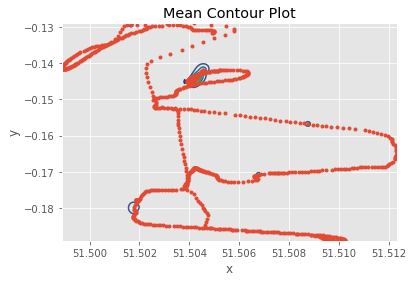

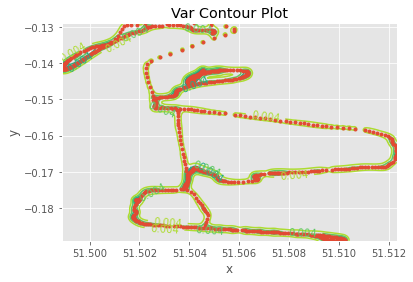

In [21]:

i = np.linspace(X[:,0].min(), X[:,0].max(), res)
j = np.linspace(X[:,1].min(), X[:,1].max(), res)
X1, Y1 = np.meshgrid(i, j)
print('predicting')
mean, var = m.predict_y(np.array([np.reshape(X1,(-1,)).T,np.reshape(Y1,(-1,))]).T)

print('predicted')
# use actual x values now computed


i = np.linspace(Xarr[:,0].min(), Xarr[:,0].max(), res)
j = np.linspace(Xarr[:,1].min(), Xarr[:,1].max(), res)
X1, Y1 = np.meshgrid(i, j)

import matplotlib.pyplot as plt
plt.figure()
cp = plt.contour(X1, Y1, np.reshape(mean,(res,res)))
plt.clabel(cp, inline=True, 
          fontsize=10)

plt.plot(Xarr[:,0],Xarr[:,1],'.')
plt.title('Mean Contour Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


plt.figure()
cp = plt.contour(X1, Y1, np.reshape(var,(res,res)))
plt.clabel(cp, inline=True, 
          fontsize=10)

plt.plot(Xarr[:,0],Xarr[:,1],'.')
plt.title('Var Contour Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# plt.figure()
# plt.plot(X[:,0],Y,'b.')
# plt.figure()
# plt.plot(Y,X[:,1],'b.')

In [19]:
from PIL import Image
from matplotlib import cm


nm = mean.numpy()
nm/= nm.max()

alpha = var.numpy()
alpha -= alpha.min()
alpha /= alpha.max()


                 
im = Image.fromarray(np.uint8(cm.plasma(np.reshape(nm,(res,res)))*255))
print('im1')
im_alpha = Image.fromarray(np.uint8(cm.gist_earth(np.reshape((1-alpha)+.5,(res,res)))*255)).convert('L')
print('im2s')
im.putalpha(im_alpha)


im.show()
# im_alpha.show()

desc = '*%.4f_%.4f'%tuple(Xarr.min(axis=0))+'*%.4f_%.4f'%tuple(Xarr.max(axis=0))+ '*%.4f_%.4f'%(Yarr.min()**1/root,Yarr.max())

im.save(what+str(res)+'*result%s.png'%desc)
im_alpha.save(what+str(res)+'*alpha%s.png'%desc)


im1
im2s


In [9]:
# plt.figure()
# plt.plot(range(len(X)),Y**1/root)
# plt.plot(range(len(X)),Y)

# 1/root

